# Анализ убытков развлекательного приложения


### Структура проекта:
- Загрузим данные и подготовим их к анализу
- Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии
- Исследовательский анализ данных. Выясним:
  - Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
  - Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
  - По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?
  - Органические пользователи
- Маркетинг. Выясним:
  - Сколько денег потратили? Всего / на каждый источник / по времени
  - Сколько в среднем стоило привлечение одного покупателя из каждого источника?
- Оценим окупаемость рекламы для привлечения пользователей. С помощью LTV и ROI:
  - Проанализируем общую окупаемость рекламы;
  - Проанализируем окупаемость рекламы с разбивкой по устройствам;
  - Проанализируем окупаемость рекламы с разбивкой по странам;
  - Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.
- Ответим на вопросы:
  - Окупается ли реклама, направленная на привлечение пользователей в целом? 
  - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
  - Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

- Выводы

### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.options.display.max_columns = 30
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
visits = pd.read_csv('C:\\Users\\admin\\Documents\\Project Python\\Метрики\\visits_info_short.csv')
orders = pd.read_csv('C:\\Users\\admin\\Documents\\Project Python\\Метрики\\orders_info_short.csv')
costs = pd.read_csv('C:\\Users\\admin\\Documents\\Project Python\\Метрики\\costs_info_short.csv')

In [3]:
# Функция первого просмотра
def first_look(df):
    df.info()
    print('-----------------------------------------------------------')
    display(df.head())
    print('-----------------------------------------------------------')
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ:', df.duplicated().sum()) 
    print('-----------------------------------------------------------')
    for column in df.columns:
        if len(df[column].unique())>50:
            print('РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА', column)
            print(df[column].describe())
            print('-----------------------------------------------------------')
        else:
            print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА', column)
            print(df[column].unique())
            print('-----------------------------------------------------------')

In [4]:
first_look(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
-----------------------------------------------------------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


-----------------------------------------------------------
КОЛИЧЕСТВО ДУБЛИКАТОВ: 0
-----------------------------------------------------------
РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА User Id
count           309,901.00
mean    499,766,449,382.69
std     288,789,916,887.83
min             599,326.00
25%     249,369,122,776.00
50%     498,990,589,687.00
75%     749,521,111,616.00
max     999,999,563,947.00
Name: User Id, dtype: float64
-----------------------------------------------------------
УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Region
['United States' 'UK' 'France' 'Germany']
-----------------------------------------------------------
УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Device
['iPhone' 'Mac' 'Android' 'PC']
-----------------------------------------------------------
УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Channel
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
--------------------------------------------------------

In [5]:
first_look(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
-----------------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


-----------------------------------------------------------
КОЛИЧЕСТВО ДУБЛИКАТОВ: 0
-----------------------------------------------------------
РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА User Id
count            40,212.00
mean    499,029,531,203.23
std     286,093,675,967.16
min             599,326.00
25%     251,132,440,436.75
50%     498,283,972,665.00
75%     743,332,711,780.00
max     999,895,427,370.00
Name: User Id, dtype: float64
-----------------------------------------------------------
РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА Event Dt
count                   40212
unique                  40163
top       2019-10-26 06:49:22
freq                        2
Name: Event Dt, dtype: object
-----------------------------------------------------------
УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Revenue
[ 4.99  5.99  9.99 49.99 19.99]
-----------------------------------------------------------


In [6]:
first_look(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
-----------------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


-----------------------------------------------------------
КОЛИЧЕСТВО ДУБЛИКАТОВ: 0
-----------------------------------------------------------
РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА dt
count           1800
unique           180
top       2019-05-01
freq              10
Name: dt, dtype: object
-----------------------------------------------------------
УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА Channel
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']
-----------------------------------------------------------
РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ СТОЛБЦА costs
count   1,800.00
mean       58.61
std       107.74
min         0.80
25%         6.50
50%        12.29
75%        33.60
max       630.00
Name: costs, dtype: float64
-----------------------------------------------------------


In [7]:
list_dfs = [visits, orders, costs]
# Переименуем столбцы 
for df in list_dfs:
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]

# Приведем нужные колонки к формату даты
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

visits.info()
print('-----------------------------------------------')
orders.info()
print('-----------------------------------------------')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64

## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии
### Таблицы

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start']).groupby('user_id')
                        .agg({'session_start': ['first', 'last'],
                              'channel': 'first',
                              'device': 'first',
                              'region': 'first'}).reset_index())
    profiles.columns = ['user_id', 'first_ts', 'last_ts', 'channel', 'device', 'region']

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'}))
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'}))

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Визуализация

In [12]:
# функция для визуализации количества пользователей по группам

def plot_user(profiles, sign):
    # Делаем группировку по признаку для всех и платящих пользователей
    all_users = profiles.groupby(sign)['user_id'].count()
    payment_users = profiles[profiles['payer'] == True].groupby(sign)['user_id'].count()
    # Строим график
    plt.figure(figsize=(10, 5))
    all_users.plot(grid=True, label = 'Все пользователи', legend=True)
    payment_users.plot(grid=True, label = 'Платящие пользователи', legend=True)
    plt.xlabel(sign)
    plt.title(f'Разбивка пользователей по {sign}')
    plt.show()
    # Делаем сводную таблицу с числами
    tab = all_users.reset_index().merge(payment_users.reset_index(), on=sign)
    tab.columns = [sign, 'all_users', 'payment_users']
    tab['conversion'] = tab['payment_users'] / tab['all_users'] * 100
    tab = tab.sort_values('conversion', ascending=False)
    return(tab)

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей', fontsize=14)

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']]
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(horizon), fontsize=14)

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon), fontsize=14)
    
    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))
    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей', fontsize=14)
    
    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon), fontsize=14)

    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize=14)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей', fontsize=14)

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize=14)
    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

### Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)
# Уберем органических пользователей, чтобы они не искажали картину, их мы рассмотрмм отдельно
profiles_or = profiles[profiles['channel'] == 'organic']
profiles = profiles[profiles['channel'] != 'organic']
display(profiles.head())
# Определим минимальную и максимальную дату привлечения пользователей
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
print('Минимальная дата привлечения:', min_date)
print('Максимальная дата привлечения:', max_date)
dates = pd.date_range(start=min_date, end=max_date)
print(f"Изучаем данные за период: {len(dates)} дней")

,user_id,first_ts,last_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,2019-05-09 07:33:16,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,2019-07-10 22:27:24,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
3,22593348,2019-08-22 21:35:48,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23
7,46006712,2019-06-30 03:46:29,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.01


Минимальная дата привлечения: 2019-05-01 00:00:41
Максимальная дата привлечения: 2019-10-27 23:59:04
Изучаем данные за период: 180 дней


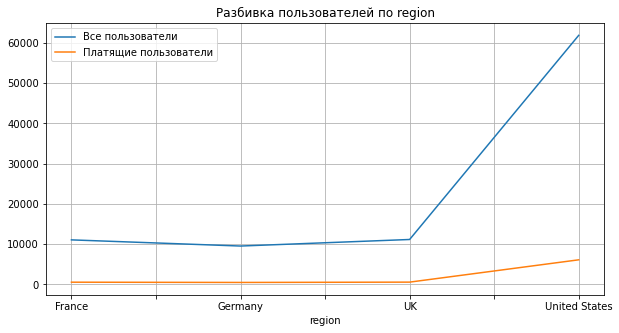

,region,all_users,payment_users,conversion
3,United States,61829,6108,9.88
1,Germany,9528,490,5.14
2,UK,11154,569,5.10
0,France,11058,554,5.01


In [18]:
plot_user(profiles, 'region')

### Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

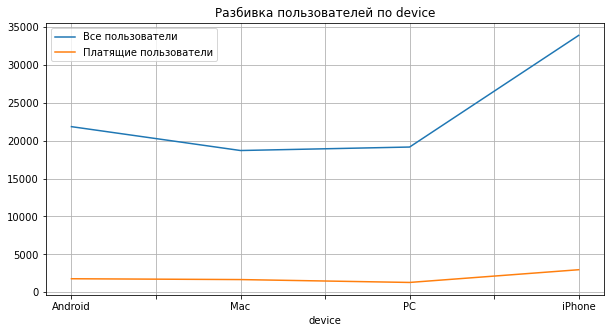

,device,all_users,payment_users,conversion
1,Mac,18693,1673,8.95
3,iPhone,33882,2972,8.77
0,Android,21841,1782,8.16
2,PC,19153,1294,6.76


In [19]:
plot_user(profiles, 'device')

### По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

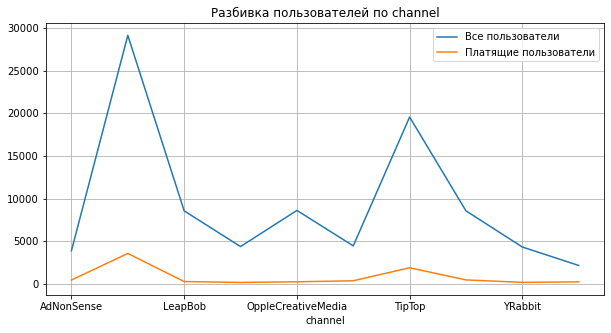

,channel,all_users,payment_users,conversion
1,FaceBoom,29144,3557,12.20
0,AdNonSense,3880,440,11.34
9,lambdaMediaAds,2149,225,10.47
6,TipTop,19561,1878,9.60
5,RocketSuperAds,4448,352,7.91
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
3,MediaTornado,4364,156,3.57
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71


In [20]:
channel_users = plot_user(profiles, 'channel')
channel_users

In [21]:
# Проверим предположение, что пользователи девайсов Mac и iPhone преимущественно из USA
countries_device = profiles.pivot_table(index='region', columns='device', values='user_id', aggfunc='nunique').reset_index()
countries_device['sum'] = countries_device['Android'] + countries_device['Mac'] + countries_device['PC'] + countries_device['iPhone']

countries_device = countries_device.sort_values('sum', ascending=False)
for col in countries_device.columns[1:]:
    countries_device[col] = countries_device[col] / countries_device['sum'].sum() *100
countries_device

device,region,Android,Mac,PC,iPhone,sum
3,United States,13.29,16.48,6.86,29.44,66.08
2,UK,3.47,1.16,4.86,2.43,11.92
0,France,3.54,1.24,4.69,2.35,11.82
1,Germany,3.04,1.09,4.06,1.99,10.18


### Органические пользователи

In [22]:
# Отдельно рассмотримм органических пользователей
organic = profiles_or.pivot_table(index='region', columns='device', values='user_id', aggfunc='nunique')
organic['sum'] = organic['Android'] + organic['Mac'] + organic['iPhone'] + organic['PC']
display(organic.sort_values('sum', ascending=False))

organic_p = profiles_or[profiles_or['payer'] == True].pivot_table(index='region', columns='device', values='user_id', aggfunc='nunique')
organic_p['sum'] = organic_p['Android'] + organic_p['Mac'] + organic_p['iPhone'] + organic_p['PC']
display(organic_p.sort_values('sum', ascending=False))

print('Всего пользователей:', organic['sum'].sum())
print('Платящих  пользователей:', organic_p['sum'].sum())
print('Конверсия:', organic_p['sum'].sum()/organic['sum'].sum()*100)

device,Android,Mac,PC,iPhone,sum
region,,,,,
United States,7763,9418,4011,16981,38173
UK,1898,692,2587,1244,6421
France,1939,675,2556,1222,6392
Germany,1591,564,2148,1150,5453


device,Android,Mac,PC,iPhone,sum
region,,,,,
United States,170,199,85,340,794
UK,29,14,58,30,131
Germany,38,13,53,22,126
France,31,13,47,18,109


Всего пользователей: 56439
Платящих  пользователей: 1160
Конверсия: 2.055316359255125


### Выводы
- USA является лидером по привлечению пользователей, обладая также наивысшей конверсией в платящих пользователей 10% против 5% (в среднем для всех остальных регионов)
- Несколько большей конверсией в платящих обладают пользователи девайсов компании Apple, что связано с их распространненостью в USA, самой низкой девайсы PC.
- Каналы привлечения разделим на 3 группы эффективности исходя из конверсии: 
  - Высокая(>10%) - FaceBoom, AdNonSense, lambdaMediaAds	
  - Средняя(5>10%) - TipTop, RocketSuperAds, WahooNetBanner
  - Низкая(<5%) - YRabbit, MediaTornado, LeapBob, OppleCreativeMedia
- Органические пользователи имееют самую низкую конверсию, их соотношение дублирует общее число пользователей по регионам.

## Маркетинг

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Text(0.5, 1.0, 'Траты на рекламу по дням')

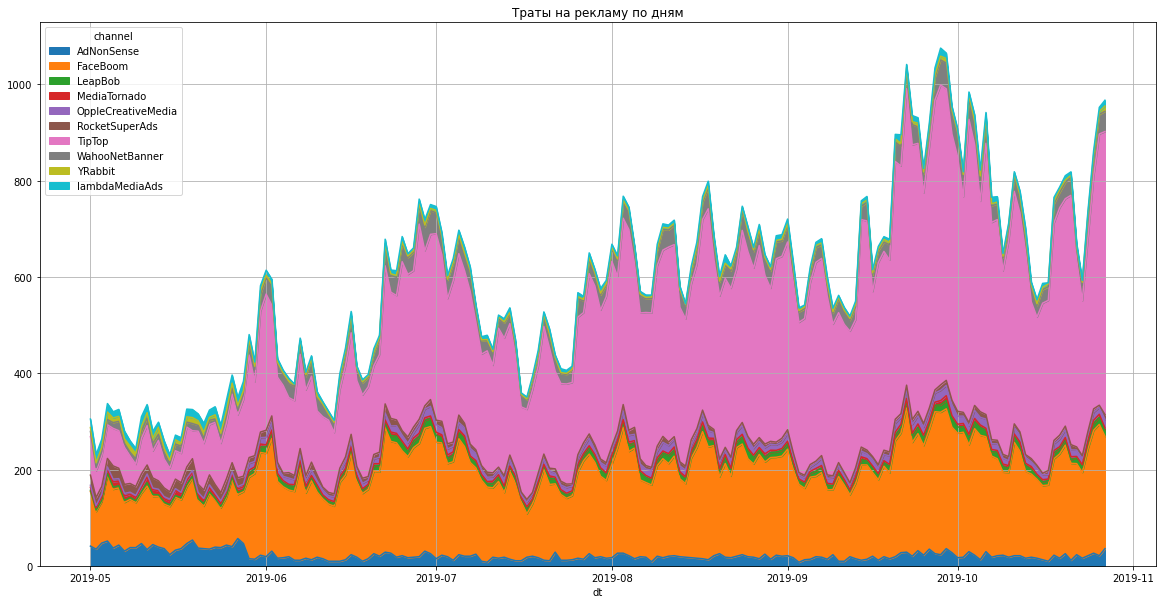

In [23]:
# Строим сводную таблицу
time_costs = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')  

time_costs.plot.area(grid=True, figsize=(20,10))
plt.title('Траты на рекламу по дням')

,channel,all_users,costs,per_user
3,TipTop,19561,"54,751.30",2.80
0,FaceBoom,29144,"32,445.60",1.11
1,AdNonSense,3880,"3,911.25",1.01
2,lambdaMediaAds,2149,"1,557.60",0.72
5,WahooNetBanner,8553,"5,151.00",0.60
4,RocketSuperAds,4448,"1,833.00",0.41
6,YRabbit,4312,944.22,0.22
7,MediaTornado,4364,954.48,0.22
8,LeapBob,8553,"1,797.60",0.21


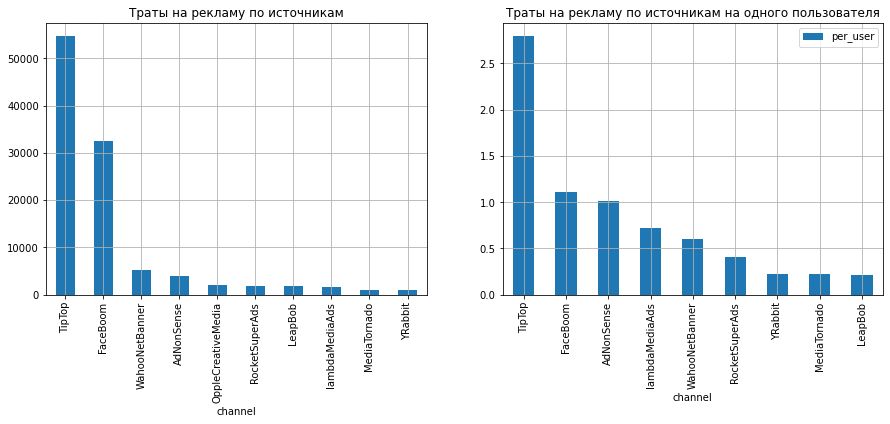

In [24]:
# Делаем группировку,  чтобы вычислить сумму трат на каждый канал привлечения
channel_costs = costs.groupby('channel')['costs'].agg(sum).sort_values(ascending=False)
#Строим
ax1 = plt.subplot(1, 2, 1)
channel_costs.plot(kind='bar', grid=True, figsize=(15,5), ax=ax1) 
plt.title('Траты на рекламу по источникам')


channel_costs = channel_costs.reset_index()
costs_per_user = channel_users.merge(channel_costs, on='channel', how='left')[['channel', 'all_users', 'costs']].head(9)
costs_per_user['per_user'] = costs_per_user['costs'] / costs_per_user['all_users']
costs_per_user = costs_per_user.sort_values('per_user', ascending=False)

ax2 = plt.subplot(1, 2, 2)
costs_per_user.plot(x='channel', y='per_user', kind='bar', grid=True, figsize=(15,5), ax=ax2)
plt.title('Траты на рекламу по источникам на одного пользователя')

costs_per_user


In [25]:
sum_costs = costs['costs'].sum().round(1)
print('ВСЕГО ПОТРАЧЕНО НА РЕКЛАМУ:', sum_costs)

ВСЕГО ПОТРАЧЕНО НА РЕКЛАМУ: 105497.3


**Выводы:**
- Всего на рекламу было потрачено 105497.3

- Самыми дорогими источниками исходя из цены за одного пользователя оказались: TipTop, FaceBoom, AdNonSense. Как можно увидеть из графика финансирования  для TipTop и FaceBoom компания увеличивала бюджет с течением времени и отметим канал привлечения AdNonSense, который при достаточно низком финансировании показывает большую стоимость за одного пользователя, что так же говорит о его невыгодности.
- Наиболее выгодными при расчете цены на одного пользователя являются: OppleCreativeMedia, YRabbit, MediaTornado, LeapBob. При этом для YRabbit и MediaTornado финансирование наоборот было урезано с течением времени.


На первый взгляд приоритеты финансированя расставлены неправильно, акцент сделан на более дорогие каналы привлечения, возможно это связано с моделью рекламы, которая привлекает более "качественных" пользователей с большим удержанием, но так ли это на самом деле еще предстоит выяснить.

## Оценим окупаемость рекламы для привлечения пользователей

In [26]:
# Зададим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
# Уберем органических пользователей, чтобы они не искажали картину
profiles = profiles[profiles['channel'] != 'organic']
profiles['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

### Общая окупаемость рекламы

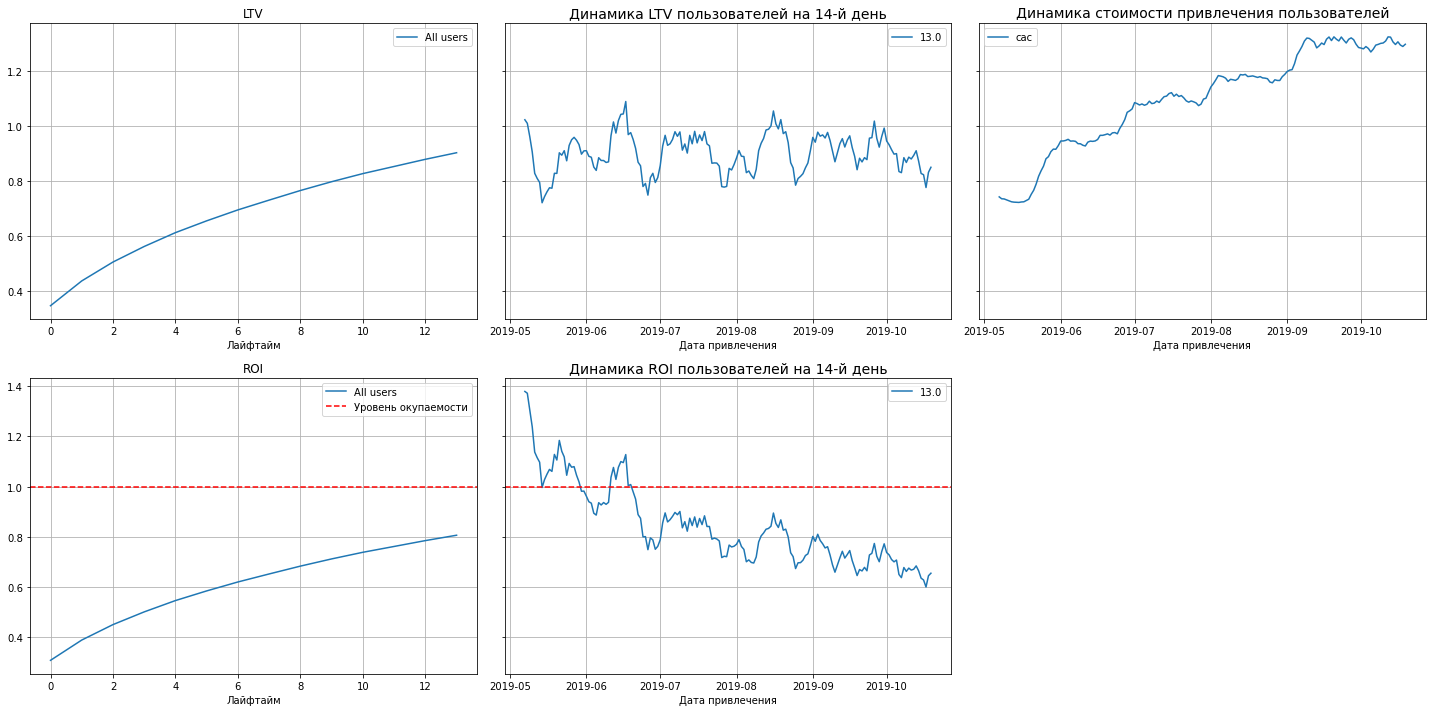

In [27]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles,
            orders,
            observation_date,
            horizon_days,
            dimensions=[])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Реклама не окупается. ROI в конце недели — чуть выше 80%. 
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- CAC стабильно растет, а значит расходы на рекламу увеличиваются, видимо проблема как раз в этом.

### Окупаемость рекламы с разбивкой по устройствам

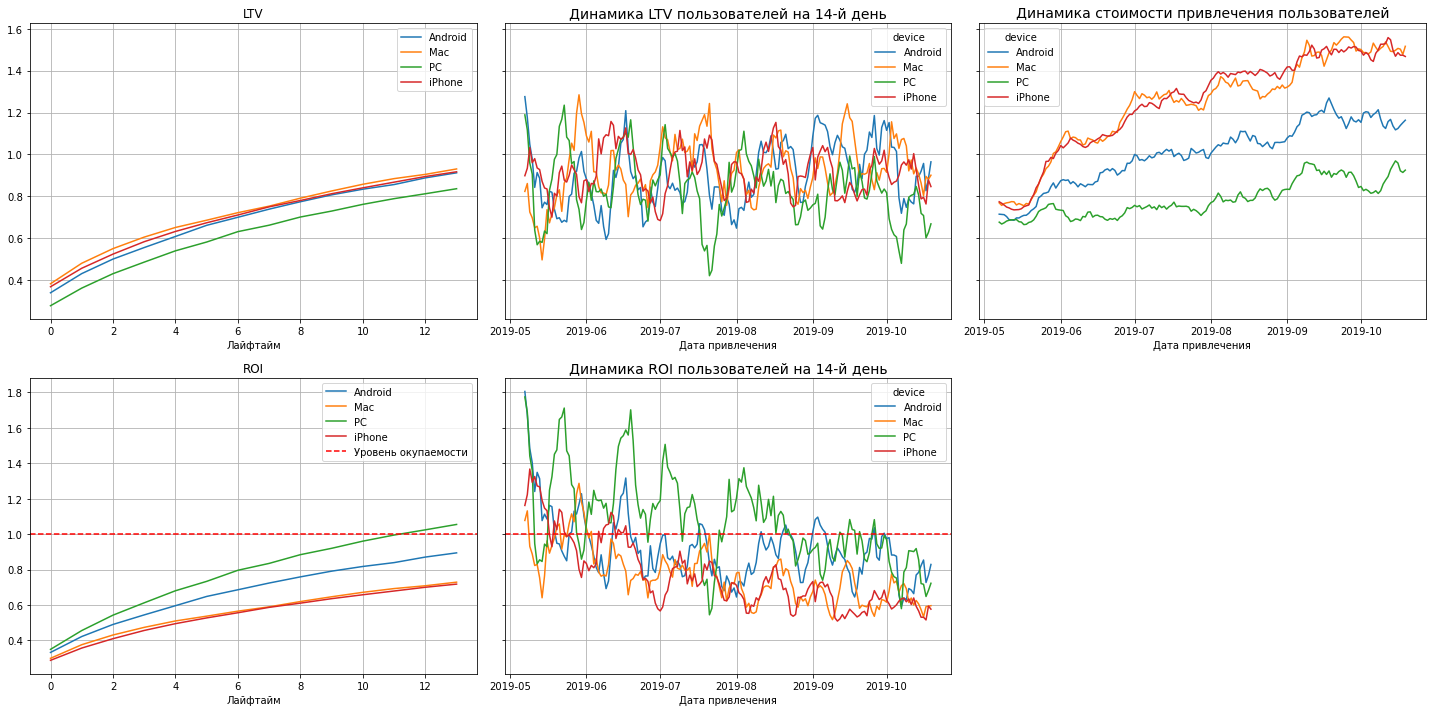

In [28]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles,
            orders,
            datetime(2019, 11, 1).date(),
            14,
            dimensions=['device'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Видим что окупаются только пользователи PC, CAC для пользователя этого устройства самый низкий, однако если тенденция увеличения трат на рекламу продолжится, не окупятся даже эти устройства
- Затраты на рекламу девайсов компании Apple самые высокие

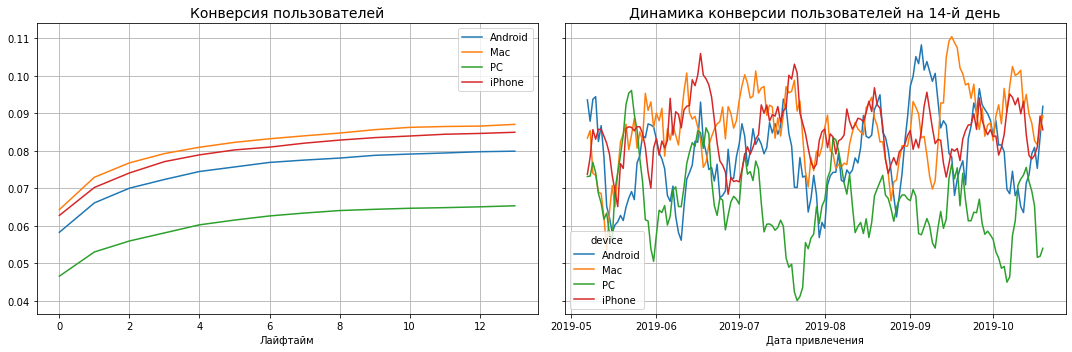

In [29]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

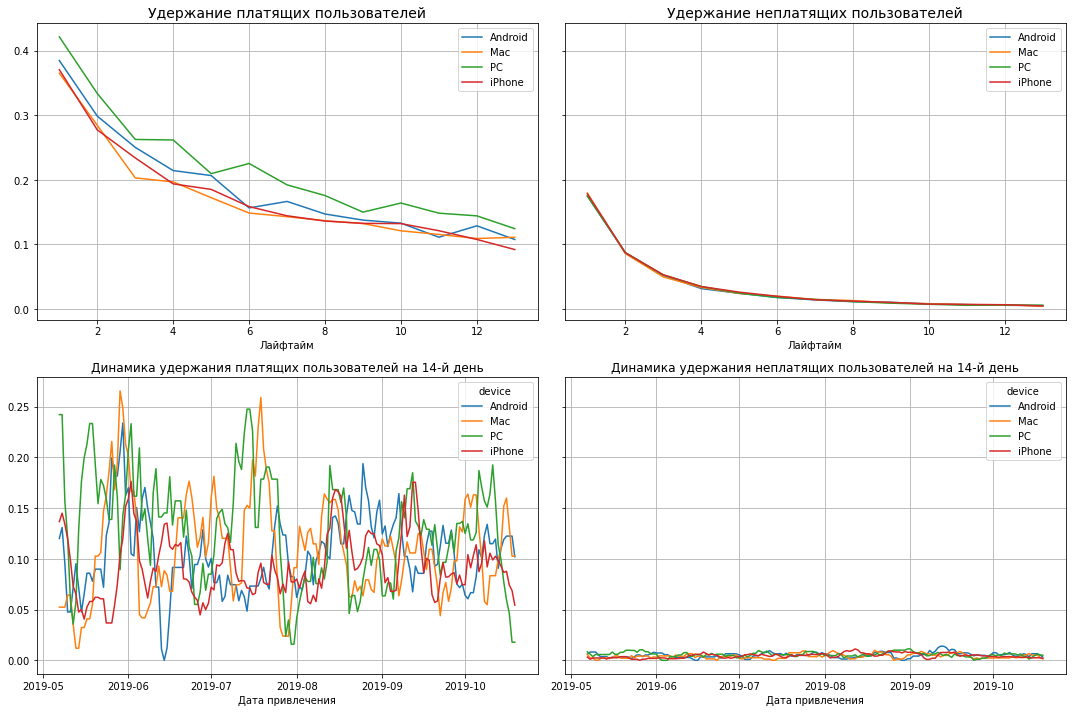

In [30]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Конверсия и удержание пользователей девайсов компании Apple на нормальном уровне в сравнении с другими устройствами получается окупаемость связанна именно с бюджетом выделенным на рекламу на этих устройствах.
- Пользователи PC обладают самой низкой конверсией, однако это компенсируется самым высоким удержанием.

### Окупаемость рекламы с разбивкой по странам

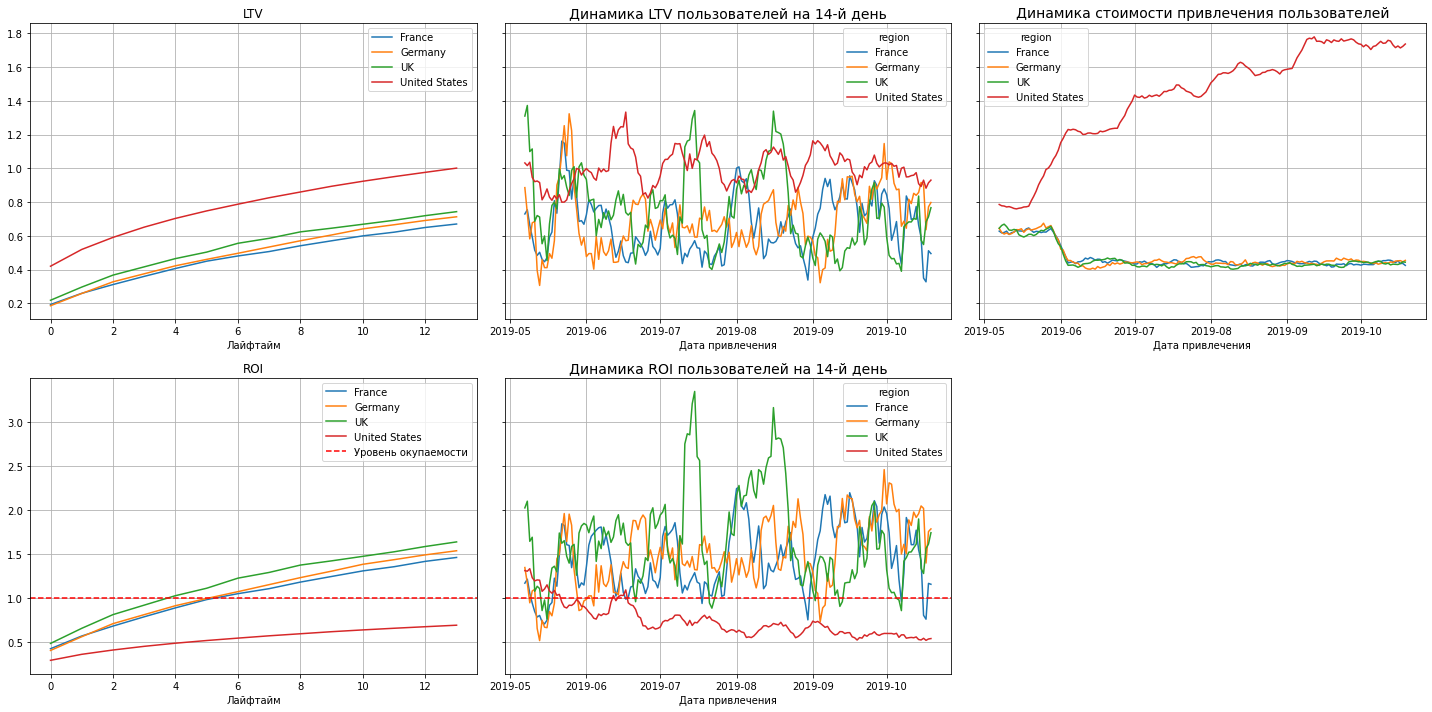

In [31]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles,
            orders,
            datetime(2019, 11, 1).date(),
            14,
            dimensions=['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Реклама не окупается только в USA и CAC в этой стране стабильно растет.
- для стран Европы CAC наоборот уменьшился и, как следствие, окупаемость в этих регионах наступает уже за 6 и меньше дней 
- отметим, что в USA самый высокий и стабильный LTV, что говорит о качестве пользователей из этой страны, на что, видимо, и была сделана ставка, при распределении бюджета.

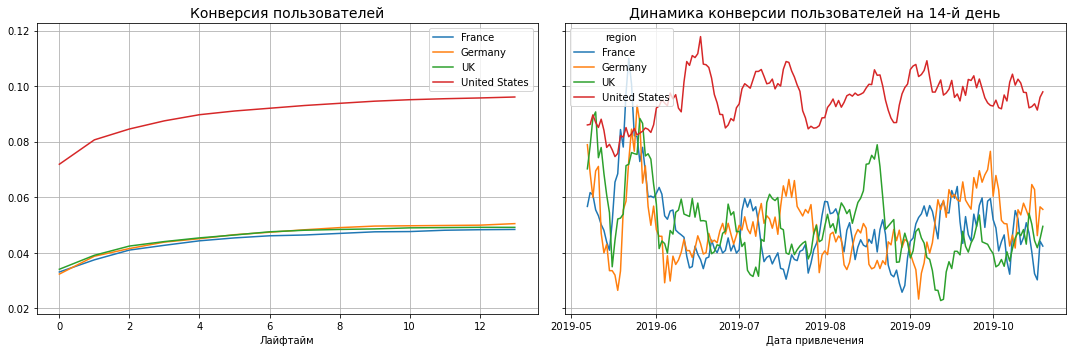

In [32]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

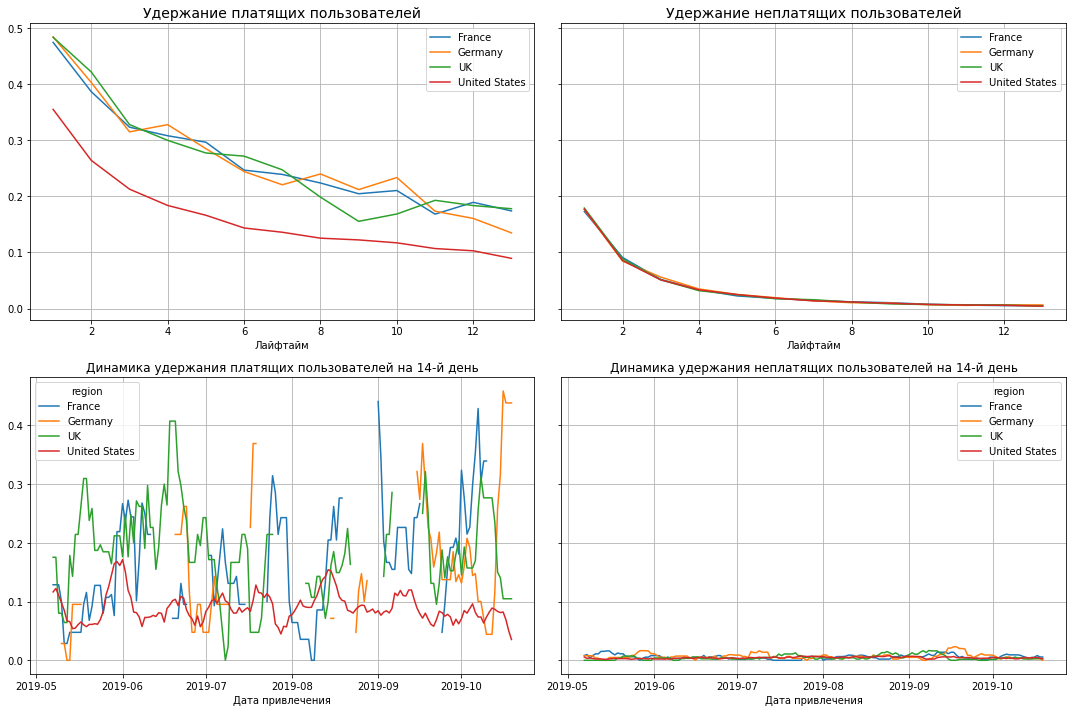

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- USA обладает самой высокой конверсией, но при этом стабильно низким удержанием пользователей, что опять же нам говорит о том, что метрика ужержанияя более важна для прибыльности.
- Динамика удержания в регионах Европы значительно лучше, однако необходимо отметить большую нестабильность, возможно эти регионы больше подвержены сезонности.

### Окупаемость рекламы с разбивкой по рекламным каналам

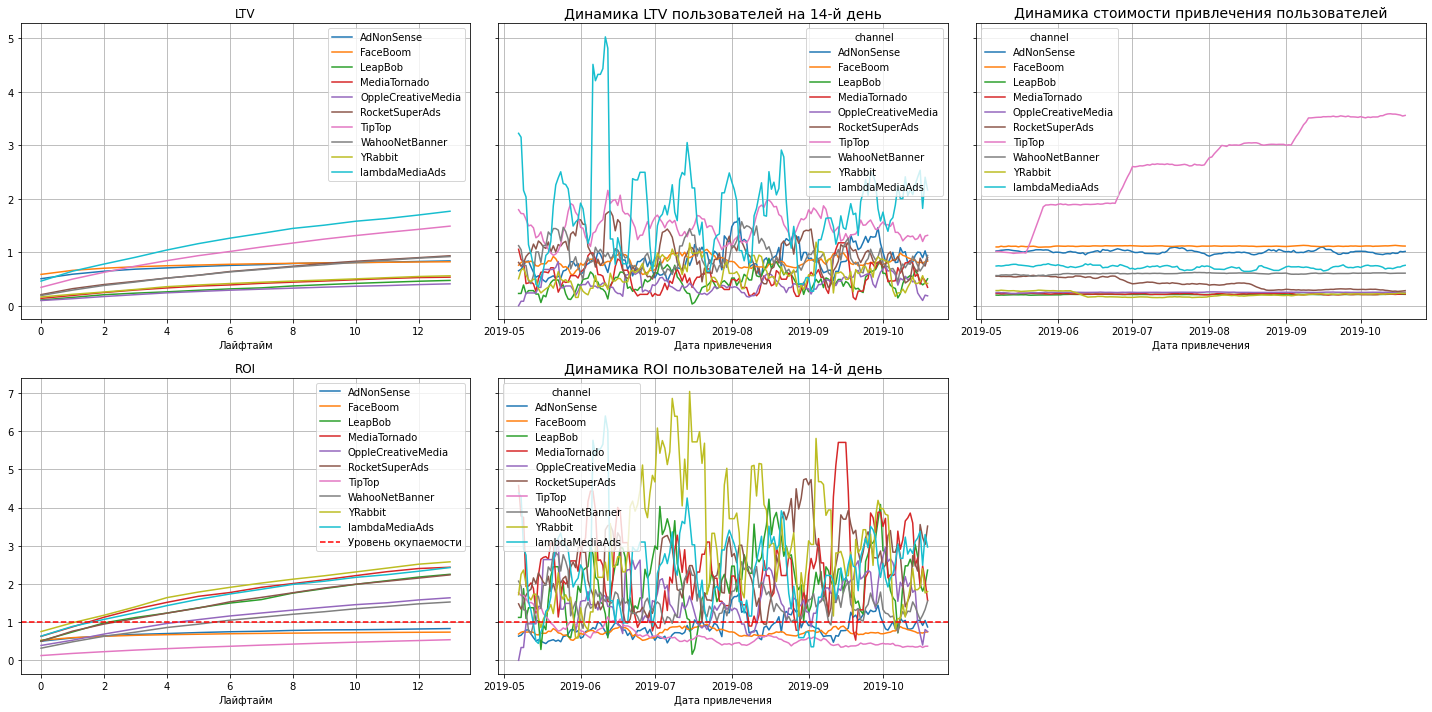

In [34]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles,
            orders,
            datetime(2019, 11, 1).date(),
            14,
            dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Очень много линий. Разобьем график на окупаемые и не окупаемые каналы привлечения**

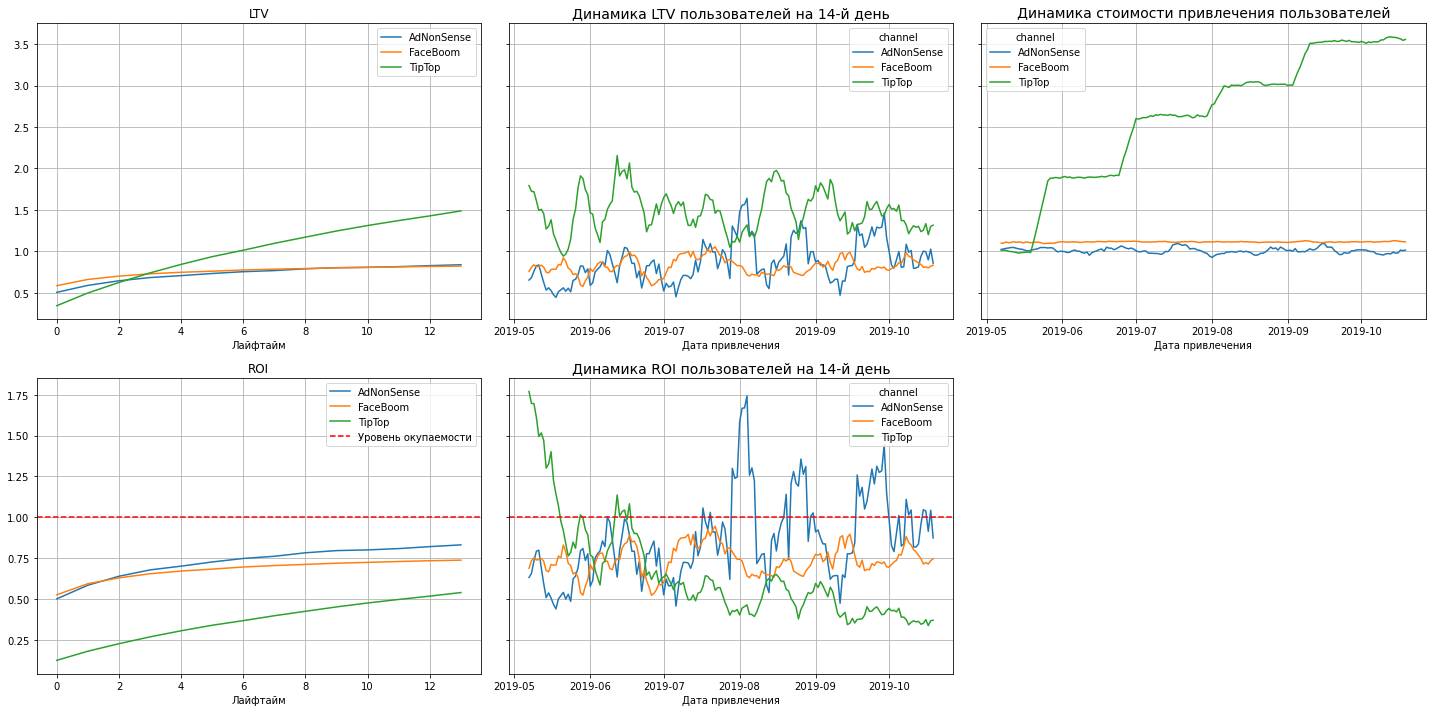

In [35]:
# Добавим разбивку по рекламным каналам чтобы сделать графики более понятными
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles[(profiles['channel'] == 'TipTop') | (profiles['channel'] == 'FaceBoom') | (profiles['channel'] == 'AdNonSense')],
            orders,
            datetime(2019, 11, 1).date(),
            14,
            dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Наименее не окупаемым каналом является TipTop и, как мы видим именно этот канал требовал постоянного увеличение бюджета при неизменном  LTV, хотя на старте имеет один из самых высоких LTV возможно именно это и послужило стимулом дальнейшего его финансирования.
- AdNonSance и FaceBoom имеют стабильно высокий уровень CAC на фоне других каналов и так же стабильно не окупаются.

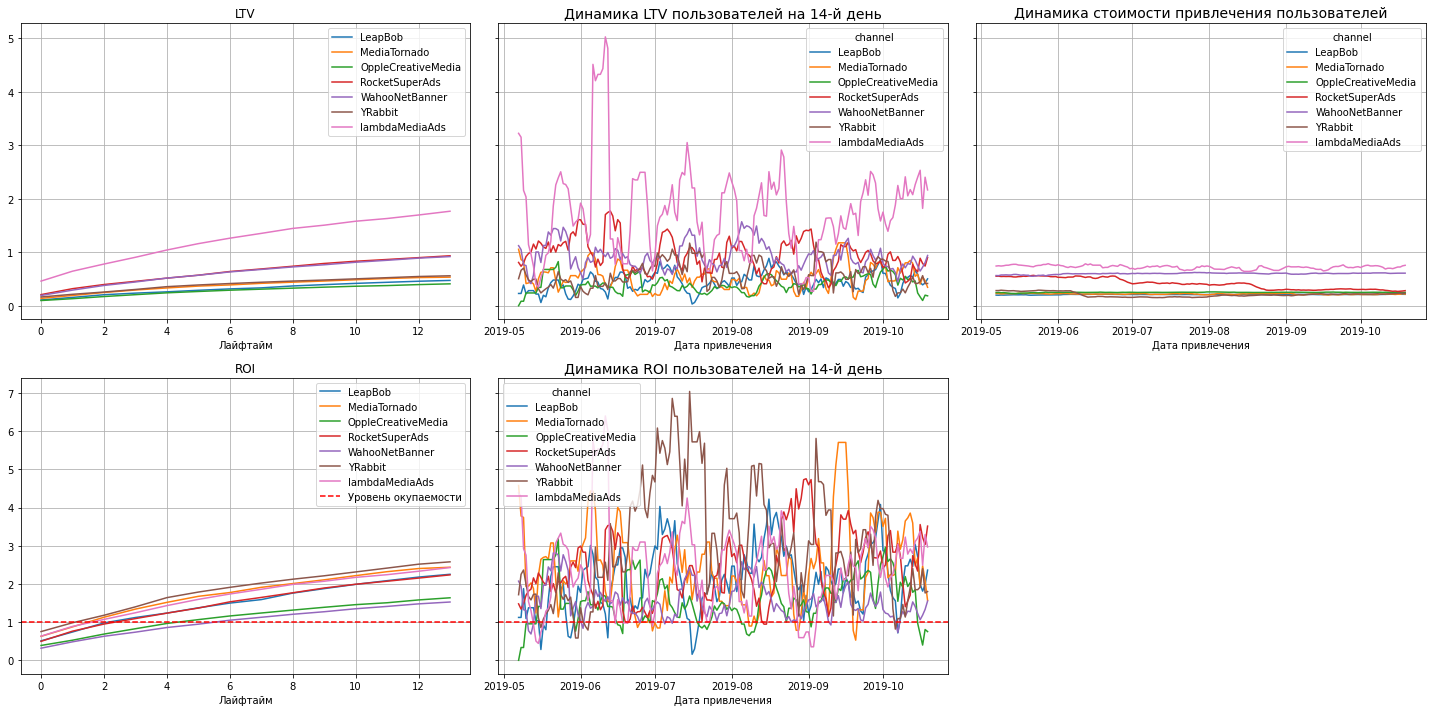

In [36]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv( 
            profiles[(profiles['channel'] != 'TipTop') & (profiles['channel'] != 'FaceBoom') & (profiles['channel'] != 'AdNonSense')],
            orders,
            datetime(2019, 11, 1).date(),
            14,
            dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Видим, что окупаемые каналы показывают более нестабильный ROI и LTV
- Канал LambdaMediaAds и имеет самый высокий и нестабильный ROI при самой высоком (из прибыльных) CAC

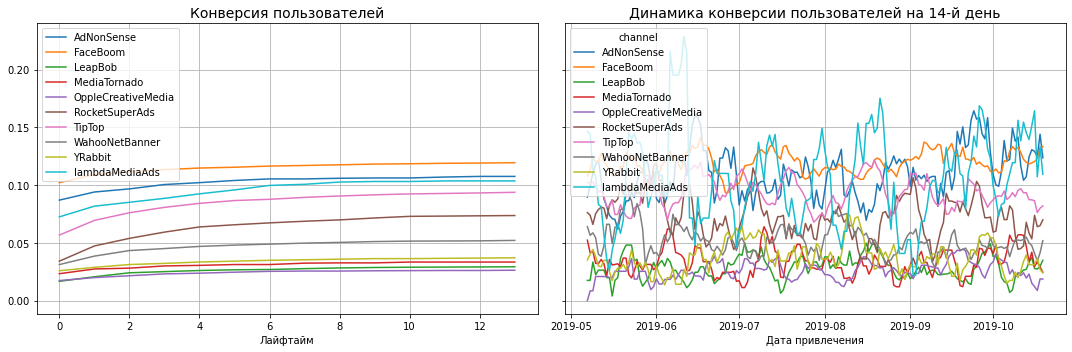

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

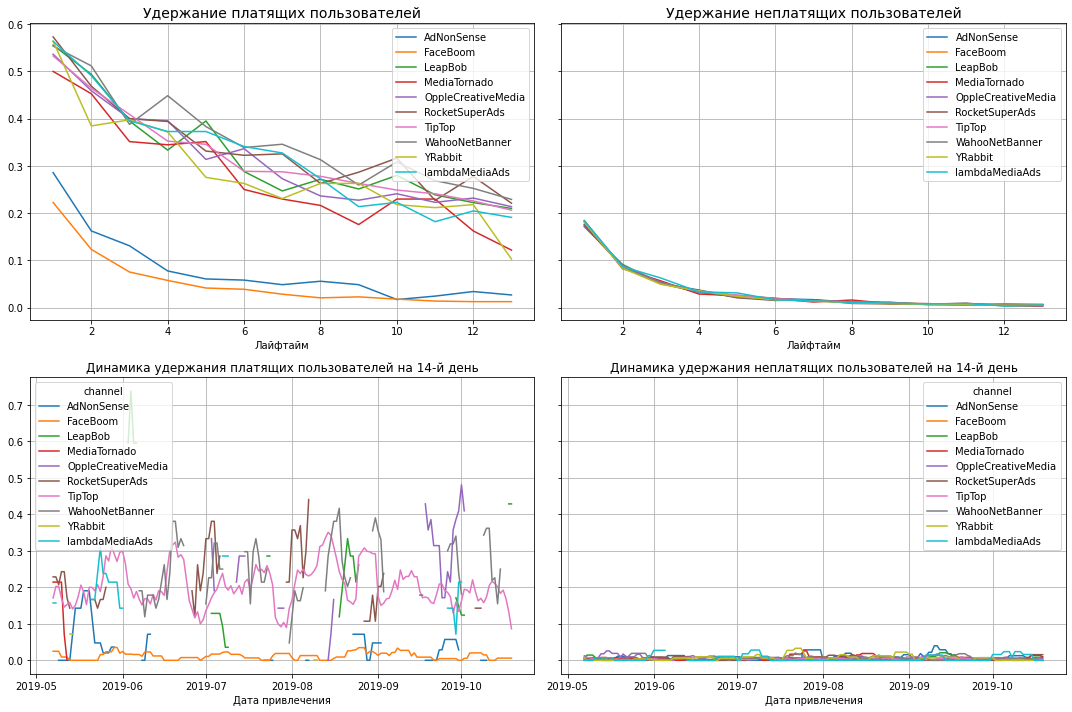

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Видим плохое удержание и конверсию для каналов AdNonSance и FaceBoom эти каналы явно неприбыльные.
- Для прибыльных каналов показатели конверсии и удержания примерно равны. Выделим итоговую 3ку лидеров :
  - RocketSuperAds
  - WahooNetBanner
  - LambdaMediaAds

In [39]:
# Подготовим финальные таблицы
def final_tab(col):
    tab_con = profiles.groupby(col).agg({'acquisition_cost':'sum', 'user_id':'nunique', 'payer': 'sum'})
    tab_con.columns = ['acquisition_cost', 'all_user', 'payer_user']
    tab_con['conversion'] = tab_con['payer_user'] / tab_con['all_user'] * 100
    tab_con['price_per_user'] = tab_con['acquisition_cost'] / tab_con['payer_user']
    costs_sum = tab_con['all_user'].sum()
    tab_con['from_total'] = tab_con['all_user'] / costs_sum *100
    tab_con = tab_con.reindex(columns=['acquisition_cost', 'all_user', 'from_total', 'payer_user', 'conversion', 'price_per_user']).sort_values(by='conversion', ascending=False)
    return(tab_con)

tab_channel = final_tab('channel')
tab_region = final_tab('region')
tab_device = final_tab('device')

## Выводы

- Всего на рекламу было потрачено 105497.3


Реклама не окупается. ROI в конце недели — чуть выше 80%. На LTV влияет сезонный фактор, но этот показатель достаточно стабилен, значит, дело не в ухудшении качества пользователей. CAC стабильно растет, а значит расходы на рекламу увеличиваются.

**Страны:**
- United States является лидером по привлечению пользователей, обладая в два раза большей  конверсией  и в два раза большим количеством привлеченных пользователей, но при этом обладая самым высоким бюджетом и ценой за одного пользователя.
- United States единственный регион где реклама не окупается, CAC в этой стране стабильно растет.
- В United States самый высокий и стабильный LTV, что говорит о качестве пользователей из этой страны, на что, видимо, и была сделана ставка, при распределении бюджета
- для стран Европы CAC наоборот уменьшается, а удержание чуть выше чем в United States и, как следствие, окупаемость в этих регионах наступает уже за 6 и меньше дней.
- динамика удержания в регионах Европы значительно лучше, однако необходимо отметить большую нестабильность, возможно эти регионы больше подвержены сезонности.

In [40]:
tab_region

,acquisition_cost,all_user,from_total,payer_user,conversion,price_per_user
region,,,,,,
United States,"90,928.60",61829,66.08,6108,9.88,14.89
Germany,"4,424.22",9528,10.18,490,5.14,9.03
UK,"5,068.50",11154,11.92,569,5.10,8.91
France,"5,075.97",11058,11.82,554,5.01,9.16


**Устройства:**
- Худшим устройством для привлечения по показателям конверсии оказался PC, обладая чуть меньшими показателями чем его конкуренты, но анализ окупаемости показал что удержание у пользователей этих устройств выше, что в общем выравнивает ситуацию. Можно сказать, что реклама не сильно зависит от конкретного устройства.
- Однако высокий рекламный бюджет и высокая стоимость за одного пользователя делает устройства компании Apple неокупаемыми.
- Устройства компании Apple представлены преимущественно в United States, а Android и PC больше распространены в Европе.

In [41]:
display(tab_device)
print('Пользователи устройств с разбивой по странам в процентах от общего числа')
countries_device

,acquisition_cost,all_user,from_total,payer_user,conversion,price_per_user
device,,,,,,
Mac,"24,094.54",18693,19.98,1673,8.95,14.40
iPhone,"43,678.79",33882,36.21,2972,8.77,14.70
Android,"22,460.63",21841,23.34,1782,8.16,12.60
PC,"15,263.34",19153,20.47,1294,6.76,11.80


Пользователи устройств с разбивой по странам в процентах от общего числа


device,region,Android,Mac,PC,iPhone,sum
3,United States,13.29,16.48,6.86,29.44,66.08
2,UK,3.47,1.16,4.86,2.43,11.92
0,France,3.54,1.24,4.69,2.35,11.82
1,Germany,3.04,1.09,4.06,1.99,10.18


**Каналы привлечения:**
- акцент финансирования сделан на более дорогие каналы привлечения с высокой конверсией, возможно это связано с моделью рекламы, которая должна была привлекать более "качественных" пользователей.
- наименее окупаемым каналом является TipTop и, как мы видим именно этот канал требовал постоянного увеличение бюджета при неизменном LTV, хотя на старте имеет один из самых высоких LTV возможно именно это возможно послужило стимулом дальнейшего его финансирования.
- AdNonSance и FaceBoom имеют стабильно высокий уровень CAC и худшее удержание на фоне других каналов и так же стабильно не окупаются.
- есть ряд недоочененых каналов привлечения со средними показателями конверсии и хорошим удержанием RocketSuperAds, WahooNetBanner, LambdaMediaAds

In [42]:
tab_channel 

,acquisition_cost,all_user,from_total,payer_user,conversion,price_per_user
channel,,,,,,
FaceBoom,"32,445.60",29144,31.15,3557,12.20,9.12
AdNonSense,"3,911.25",3880,4.15,440,11.34,8.89
lambdaMediaAds,"1,557.60",2149,2.30,225,10.47,6.92
TipTop,"54,751.30",19561,20.91,1878,9.60,29.15
RocketSuperAds,"1,833.00",4448,4.75,352,7.91,5.21
WahooNetBanner,"5,151.00",8553,9.14,453,5.30,11.37
YRabbit,944.22,4312,4.61,165,3.83,5.72
MediaTornado,954.48,4364,4.66,156,3.57,6.12
LeapBob,"1,797.60",8553,9.14,262,3.06,6.86


**Рекомендации для отдела продаж:**
- Перераспредилить бюджет на более дешевые каналы привлечения с хорошим удержанием: RocketSuperAds, WahooNetBanner, LambdaMediaAds. Однако в видду их большей нестабильности рекомендуется равномерно распределение бюджета между потенциально прибыльными каналами и плавное его повышение, чтобы снизить риски.
- Учитывать удержание при планировании рекламного бюджета.
- Увеличение удержания пользователей в регионе United States сильно повлияет на окупаемость и общую прибыль компаниию